# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

# Содержание

1. Знакомство с данными
2. Исследовательский анализ данных
3. Обучение модели
    * ResNet50
    * LeNet
4. Анализ обученной модели

## План работы

Для решения задачи заказчика проведем первичное знакомство с данными. Проверим полученный датасет на наличие ошибок. После первичного знакомства перейдем к исследовательской части проекта в котором проанализируем распределение целевого признака - возраст пользователя. В рамках исследовательской части посмотрим на фотографии пользователей и на основе фотографий предложим возможные варианты аугментаций. 

После исследовательской части выберем несколько архитектур нейросетей и проведем исследование, в процессе которого выполним требование заказчика.


## Знакомство с данными

In [3]:
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams.update({'font.size': 15})

Прежде всего, сделаем выгрузку данных для решения задачи

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим необходимую информацию:

* Количество наблюдений;
* Предоставленные признаки;
* Первые пять наблюдений;
* Распределение целевого признака (возраст)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Видим, что всего у нас 7591 наблюдение. В предоставленных данных имеется всего два поля:

* `file_name` - фотография пользователя;
* `real_age` - возраст пользователя.

Данные поля имеют типы `object` и `int`, никакх проблем на данный момент не обнаружено.

Посмотрим на первые пять наблюдений.

In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Вывод**

Мы познакомились с предоставленным заказчиком набором данных. Определили количество наблюдений, полей.

В ходе первичного знакомства установили, что набор данных не имеет проблем - в предобработке не нуждается.

## Исследовательский анализ данных

Посмотрим на количество уникальных значений целевого признака:

In [7]:
labels.real_age.sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

Видим, что в целевом признаке диапазон возраста пользователей от 1 до 100 лет.

Теперь посмотрим на значения статистических метрик целевого признака:

In [8]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

На основе этих данных видим следующее:

* Средний возраст в наборе данных составляет 31 год;
* Стандартное отклонение составляет 17 лет;
* Минимальный возраст - 1 год;
* Максимальный возраст - 100 лет;
* Первый квартиль набора данных составляет 20 лет;
* Третий квартиль - 41 лет;
* Медианный возраст пользователей в данных составляет 29 лет.

Посмотрим на количество пользователей, возраст которых составляет 1 год и 100 лет:

In [9]:
labels[labels.real_age == 1]['real_age'].count()

149

In [10]:
labels[labels.real_age == 100]['real_age'].count()

1

В предоставленном наборе данных видим, что у нас есть 149 фотографий пользователей, возраст который составляет 1 год. И только один пользователь имеет возраст 100 лет (долгожитель, все-таки).

Теперь посмотрим на распределение целевого признака. Посмотрим на гистограмму и ящик с усами.

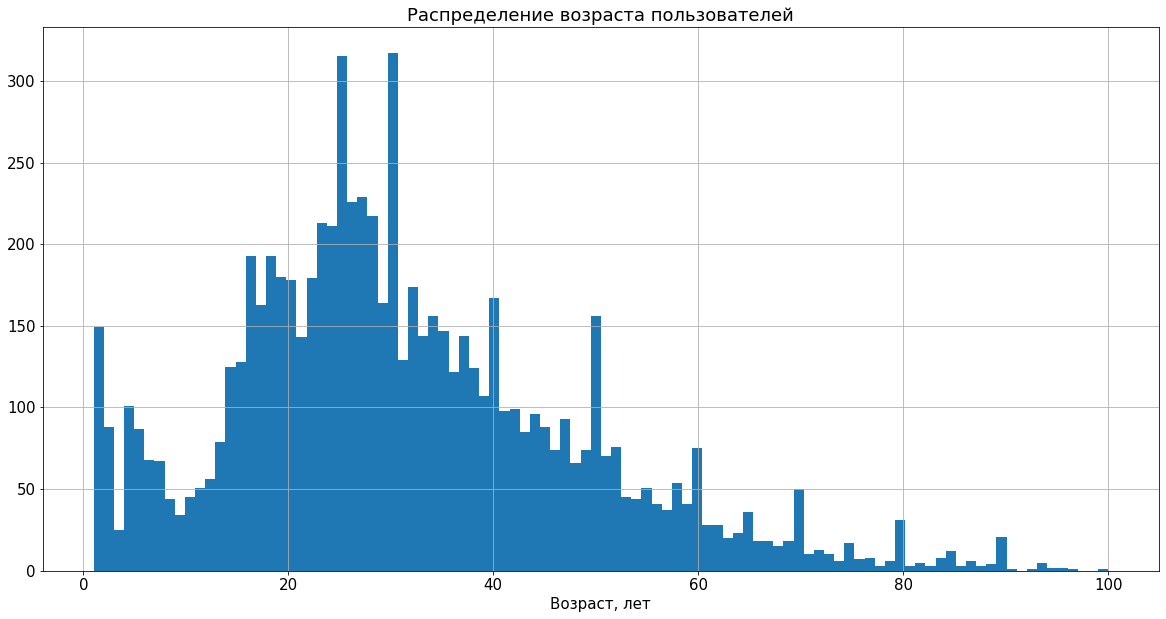

In [11]:
labels.real_age.hist(bins = 100, figsize = (20,10))
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст, лет');

Видим, что распределение целевого признака смещено в правую сторону. Распределние имеет положительное смещение.

Теперь посмотрим на ящик с усами:

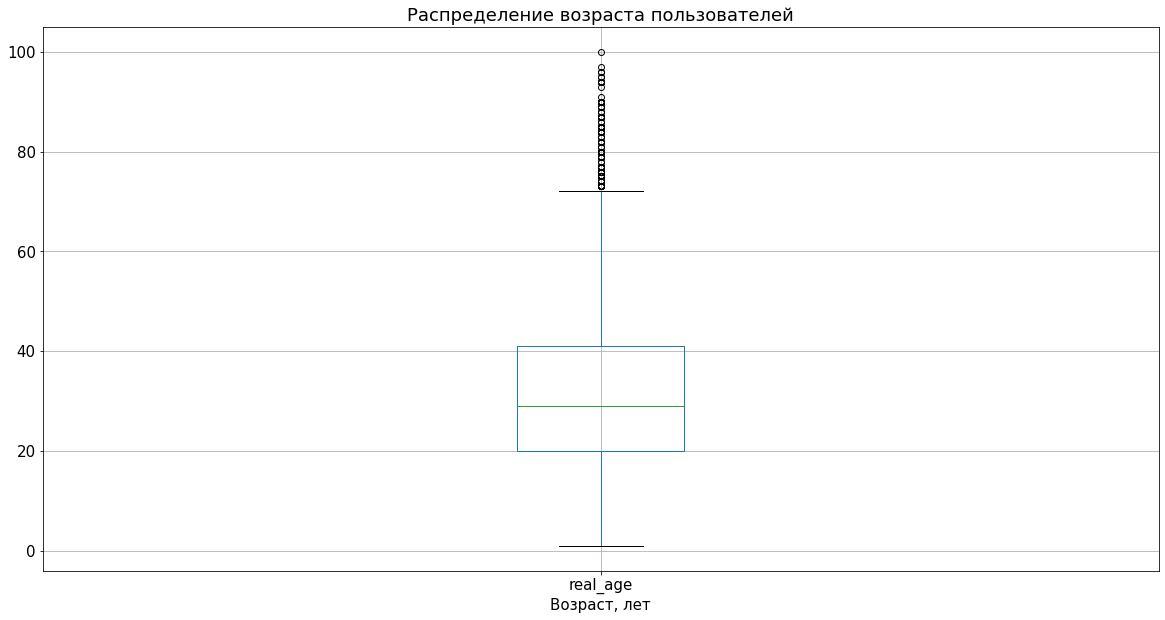

In [12]:
labels.boxplot(column=['real_age'], figsize = (20,10))
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст, лет');

В предоставленном наборе данных видим, что после 75 лет последующие значения возраста представлены как аномальные значения (их не так много).

Теперь посмотрим на фотографии пользователей.

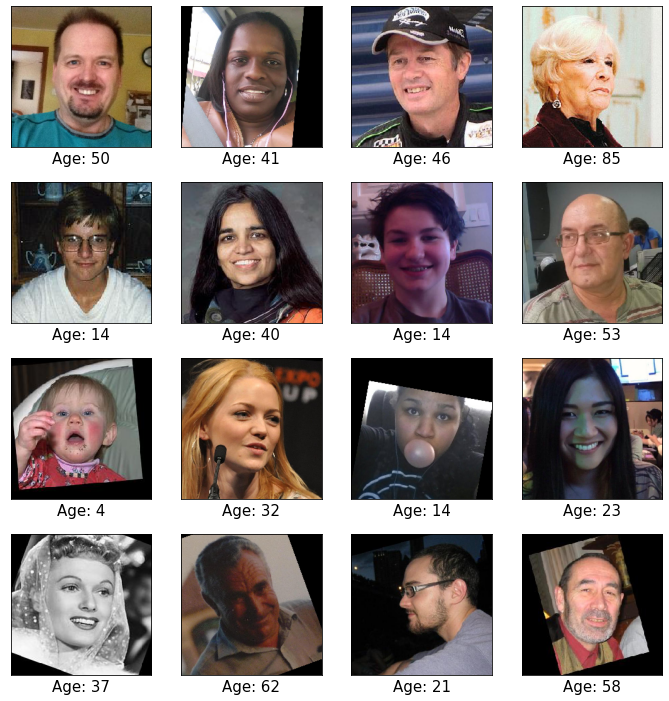

In [13]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.xlabel(f'Age: {target[i]}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

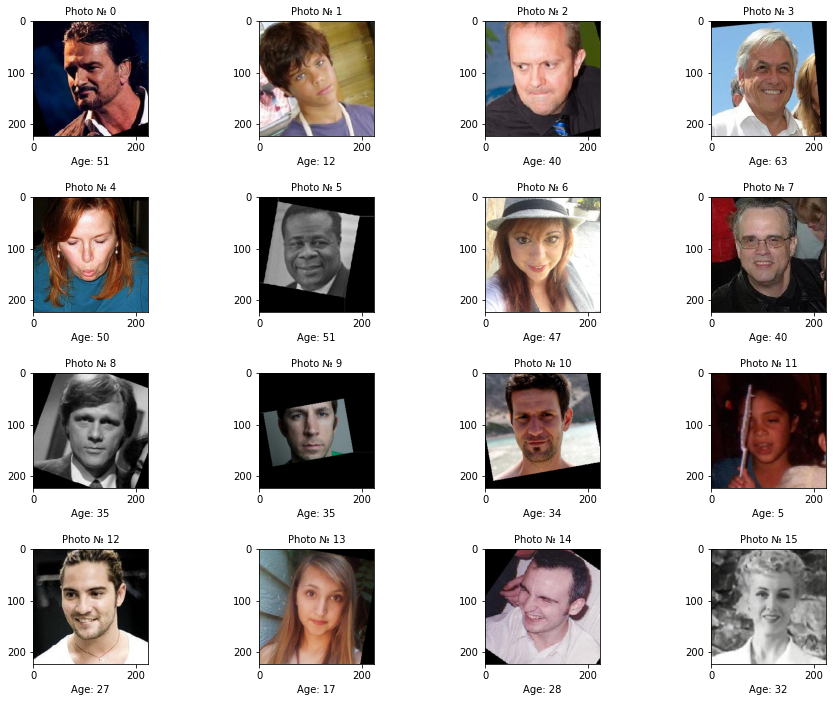

In [14]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'Photo № {i}', fontsize=10)
    plt.xlabel(f'Age: {target[i]}',fontsize=10)
    plt.imshow(features[i])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

**Вывод**

В процессе исследовательского анализа данных установили следующие тенденции:

* Данные имеют положительную скошенность: после 75 лет наблюдаются аномальные значения. Это можно обосновать тем, что у нас не такая большая выборка (около 8 тысяч наблюдений), при этом людей-долгожителей не так много;
* Имеется 149 детей с возрастом в 1 год и 1 пользователь в возрасте 100 лет;
* Средний возраст в предоставленном наборе данных равен 31 году.

Стоит добавить, что для улучшения обучения модели, а именно: увеличение значения метрики качества, так как мы работаем с фотографиями, на которой представлены люди, можно воспользоваться аугментацией:

* Зеркальное отражение (вертикаль-горизонталь);
* Повороты изображения;
* Растягивание-сжатие;
* Изменение яркости и контрастности;
* Добавление шума.

Из представленного набора данных видим следующее:

* Ориентация фотография корректная, нет фотографий перевернутых вверх-ногами;
* Имеются как цветные фотографии, так и черно-белые;
* Размер изображений различаются: есть фотографии в котором виден четкий контур лица, а есть те, в которых контур лица еле заметен;
* На некоторых фотографиях имеется искажения, шум;
* В части набора данных некоторые изображения повернуты на небольшой угол.
* Некоторые фотографии вставлены и повернуты относительно черного фона.

Данные особенности набора данных, возоможно повлияют на окончательный результат исследования. Однако нужно отметить, что одной эпохой обучения не обойтись - нужно перебрать несколько больших эпох и сравнить полученные результаты

## Обучение модели

### ResNet50

Условие заказчика: значения MAE на тестовой выборке не больше 8

В качестве модели обучения для начала воспользуемся моделью архитектуры `ResNet50`. При этом добавим аугментацию: отзеркаливание по вертикали и горизонтали. Код ниже представляет собой реализацию данной задачи. Расчеты были выполнены на облачном вычислителе.

* Модель: `ResNet50`
* Количество эпох: 5
* Шаг: 0.00005
* Аугментация: зеркальное отражение (по горизонтали и вертикали)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np

def load_train(path):
    
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.25,
                                       vertical_flip=True,
                                       horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, 
    validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.00005)

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
   
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None,
                epochs=5, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data = test_data,
              batch_size=batch_size,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2, epochs=epochs, shuffle=True)
    return model

```

Результаты вычисления:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 46s - loss: 276.7396 - mae: 12.2568 - val_loss: 864.5230 - val_mae: 24.5366
Epoch 2/5
356/356 - 38s - loss: 109.2074 - mae: 7.9719 - val_loss: 133.9938 - val_mae: 9.0427
Epoch 3/5
356/356 - 38s - loss: 83.5531 - mae: 7.0233 - val_loss: 88.2481 - val_mae: 7.0209
Epoch 4/5
356/356 - 38s - loss: 69.2968 - mae: 6.2993 - val_loss: 81.4649 - val_mae: 6.7130
Epoch 5/5
356/356 - 38s - loss: 56.2144 - mae: 5.7533 - val_loss: 87.0344 - val_mae: 6.9832
119/119 - 9s - loss: 87.0344 - mae: 6.9832
Test MAE: 6.9832

```

Теперь рассмотрим такую же модель (с такими же гиперпараметрами), но без аугментаций:

* Модель: `ResNet50`
* Количество эпох: 5
* Шаг: 0.00005
* Без аугментаций

Результаты вычисления:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 69s - loss: 260.3146 - mae: 11.6333 - val_loss: 1066.2592 - val_mae: 28.0698
Epoch 2/5
356/356 - 37s - loss: 68.0165 - mae: 6.2359 - val_loss: 157.1019 - val_mae: 9.2452
Epoch 3/5
356/356 - 37s - loss: 36.0879 - mae: 4.6143 - val_loss: 105.9806 - val_mae: 8.2706
Epoch 4/5
356/356 - 37s - loss: 25.3730 - mae: 3.9058 - val_loss: 71.5164 - val_mae: 6.4054
Epoch 5/5
356/356 - 37s - loss: 20.8930 - mae: 3.5274 - val_loss: 73.7331 - val_mae: 6.4390
119/119 - 9s - loss: 73.7331 - mae: 6.4390
Test MAE: 6.4390

```

Модель обучалась дольше, но при этом видим улучшение метрики на тестовых выборке модели без аугментаций. Однако заметим, что без аугментаций модель переобучается. Это можно заметить по значениям метрик для обучающей и тестовой выборок.

Теперь попробуем увеличить количество эпох.

* Модель: `ResNet50`
* Количество эпох: 12
* Шаг: 0.00005
* Аугментация: зеркальное отражение (по горизонтали и вертикали)

Результаты вычислений:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/12
356/356 - 69s - loss: 292.6360 - mae: 12.4819 - val_loss: 1016.8164 - val_mae: 27.2249
Epoch 2/12
356/356 - 38s - loss: 110.4447 - mae: 7.9842 - val_loss: 205.1578 - val_mae: 10.7630
Epoch 3/12
356/356 - 38s - loss: 81.0030 - mae: 6.8432 - val_loss: 93.3912 - val_mae: 7.1927
Epoch 4/12
356/356 - 38s - loss: 70.1981 - mae: 6.3457 - val_loss: 86.7076 - val_mae: 7.0138
Epoch 5/12
356/356 - 38s - loss: 60.0827 - mae: 5.8511 - val_loss: 90.5800 - val_mae: 7.1043
Epoch 6/12
356/356 - 38s - loss: 49.8988 - mae: 5.4341 - val_loss: 90.1809 - val_mae: 7.0041
Epoch 7/12
356/356 - 38s - loss: 43.4814 - mae: 4.9810 - val_loss: 81.1309 - val_mae: 6.7452
Epoch 8/12
356/356 - 38s - loss: 39.4445 - mae: 4.7936 - val_loss: 79.8612 - val_mae: 6.6853
Epoch 9/12
356/356 - 38s - loss: 34.7238 - mae: 4.4581 - val_loss: 75.7457 - val_mae: 6.4235
Epoch 10/12
356/356 - 38s - loss: 29.1443 - mae: 4.1438 - val_loss: 79.3275 - val_mae: 6.8075
Epoch 11/12
356/356 - 38s - loss: 25.2249 - mae: 3.8549 - val_loss: 78.0343 - val_mae: 6.4972
Epoch 12/12
356/356 - 38s - loss: 23.8315 - mae: 3.7113 - val_loss: 123.6175 - val_mae: 8.6033
119/119 - 9s - loss: 123.6175 - mae: 8.6033
Test MAE: 8.6033
```

* Модель: `ResNet50`
* Количество эпох: 12
* Шаг: 0.00005
* Без аугментаций

Результаты вычислений:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/12
356/356 - 124s - loss: 280.5954 - mae: 12.0149 - val_loss: 481.2175 - val_mae: 16.8505
Epoch 2/12
356/356 - 38s - loss: 67.2153 - mae: 6.2492 - val_loss: 126.3322 - val_mae: 8.8179
Epoch 3/12
356/356 - 38s - loss: 36.2638 - mae: 4.6920 - val_loss: 69.7519 - val_mae: 6.3600
Epoch 4/12
356/356 - 38s - loss: 23.9403 - mae: 3.8075 - val_loss: 72.5878 - val_mae: 6.6911
Epoch 5/12
356/356 - 38s - loss: 18.7196 - mae: 3.3228 - val_loss: 89.3643 - val_mae: 7.3247
Epoch 6/12
356/356 - 38s - loss: 15.5459 - mae: 3.0104 - val_loss: 72.0036 - val_mae: 6.4298
Epoch 7/12
356/356 - 38s - loss: 12.4110 - mae: 2.6851 - val_loss: 78.2492 - val_mae: 6.6850
Epoch 8/12
356/356 - 38s - loss: 10.4388 - mae: 2.4546 - val_loss: 67.7390 - val_mae: 6.2443
Epoch 9/12
356/356 - 37s - loss: 9.0525 - mae: 2.2626 - val_loss: 67.5211 - val_mae: 6.3397
Epoch 10/12
356/356 - 38s - loss: 8.0911 - mae: 2.1172 - val_loss: 68.8898 - val_mae: 6.3504
Epoch 11/12
356/356 - 38s - loss: 7.1465 - mae: 2.0232 - val_loss: 69.0408 - val_mae: 6.1968
Epoch 12/12
356/356 - 38s - loss: 6.6303 - mae: 1.9606 - val_loss: 65.4025 - val_mae: 6.1922
119/119 - 9s - loss: 65.4025 - mae: 6.1922
Test MAE: 6.1922
```

Видим, что добавление эпох улучшило значение метрики сети без аугментаций. Однако добавление эпох к сети с аугментацией дала результат, который не удовлетворяет требованиям заказчика.

Добавим дополнительные аугментации: 

* Повороты до 90 градусов,
* Сдвиги изображения по вертикали и горизонтали на 20% от исходного размера.

Будем менять количество эпох (5/12)

Остальные гиперпараметры останутся прежними:

* Модель: `ResNet50`
* Количество эпох: 5
* Шаг: 0.00005

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 175s - loss: 331.3595 - mae: 13.5115 - val_loss: 675.4501 - val_mae: 21.0114
Epoch 2/5
356/356 - 94s - loss: 150.6240 - mae: 9.3923 - val_loss: 146.4036 - val_mae: 9.5342
Epoch 3/5
356/356 - 94s - loss: 129.2136 - mae: 8.6858 - val_loss: 140.7375 - val_mae: 9.2429
Epoch 4/5
356/356 - 94s - loss: 114.9513 - mae: 8.1570 - val_loss: 174.2452 - val_mae: 10.1921
Epoch 5/5
356/356 - 94s - loss: 105.4026 - mae: 7.9146 - val_loss: 123.6943 - val_mae: 8.5626
119/119 - 10s - loss: 123.6943 - mae: 8.5626
Test MAE: 8.5626
```

* Модель: `ResNet50`
* Количество эпох: 12
* Шаг: 0.00005

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/12
356/356 - 102s - loss: 328.5813 - mae: 13.5673 - val_loss: 816.5716 - val_mae: 23.6811
Epoch 2/12
356/356 - 95s - loss: 146.2042 - mae: 9.2785 - val_loss: 157.5895 - val_mae: 9.7534
Epoch 3/12
356/356 - 95s - loss: 126.1260 - mae: 8.6037 - val_loss: 111.8839 - val_mae: 7.9583
Epoch 4/12
356/356 - 95s - loss: 117.2603 - mae: 8.3260 - val_loss: 221.0147 - val_mae: 12.2102
Epoch 5/12
356/356 - 95s - loss: 103.5216 - mae: 7.7873 - val_loss: 97.5218 - val_mae: 7.4176
Epoch 6/12
356/356 - 94s - loss: 98.9829 - mae: 7.5830 - val_loss: 127.4091 - val_mae: 8.7772
Epoch 7/12
356/356 - 95s - loss: 90.8511 - mae: 7.3194 - val_loss: 96.4937 - val_mae: 7.5223
Epoch 8/12
356/356 - 94s - loss: 84.1856 - mae: 7.0731 - val_loss: 101.2676 - val_mae: 7.4145
Epoch 9/12
356/356 - 95s - loss: 82.5768 - mae: 6.9662 - val_loss: 110.9072 - val_mae: 7.7192
Epoch 10/12
356/356 - 94s - loss: 79.4855 - mae: 6.8290 - val_loss: 143.0125 - val_mae: 9.3804
Epoch 11/12
356/356 - 95s - loss: 71.5158 - mae: 6.4345 - val_loss: 130.9392 - val_mae: 8.4408
Epoch 12/12
356/356 - 94s - loss: 67.8689 - mae: 6.3657 - val_loss: 109.4164 - val_mae: 7.6685
119/119 - 10s - loss: 109.4164 - mae: 7.6685
Test MAE: 7.6685
```

А вот здесь мы видим интересную тенденцию: для большого количества аугментаций (возможных модификаций изображений), чтобы получить улучшение метрики, необходимо увеличивать количество эпох. Видимо, это связано с тем, что набор данных увеличился, и для улучшения значений метрики необходимо сделать больше пробегов по набору данных.

Теперь рассмотрим другую архитектуру сети: LeNet

### LeNet

Рассмотрим следующую архитектуру: 

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten
import numpy as np

def load_train(path):
    
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                      validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.00005)

    model = Sequential()
    model.add(Conv2D(6, (5,5), padding='same', activation='relu', input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5,5), padding='valid', activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    
   
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data = test_data,
              batch_size=batch_size,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2, epochs=epochs, shuffle=True)
    return model
```

Рассмотрим сеть без аугментаций.

Результаты вычислений:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 38s - loss: 415.0961 - mae: 15.5942 - val_loss: 296.7602 - val_mae: 13.5955
Epoch 2/15
356/356 - 36s - loss: 297.7657 - mae: 13.3073 - val_loss: 286.1585 - val_mae: 13.4964
Epoch 3/15
356/356 - 35s - loss: 287.6556 - mae: 13.0596 - val_loss: 274.6647 - val_mae: 13.1553
Epoch 4/15
356/356 - 35s - loss: 279.8476 - mae: 12.8948 - val_loss: 266.9527 - val_mae: 12.9213
Epoch 5/15
356/356 - 35s - loss: 274.8874 - mae: 12.7610 - val_loss: 263.1069 - val_mae: 12.8320
Epoch 6/15
Epoch 7/15
356/356 - 36s - loss: 270.4798 - mae: 12.6619 - val_loss: 266.1966 - val_mae: 13.0190
356/356 - 36s - loss: 266.1479 - mae: 12.5620 - val_loss: 252.5476 - val_mae: 12.4143
Epoch 8/15
Epoch 9/15
356/356 - 36s - loss: 261.7959 - mae: 12.4619 - val_loss: 257.9971 - val_mae: 12.7818
356/356 - 36s - loss: 260.1148 - mae: 12.4057 - val_loss: 247.5082 - val_mae: 12.2086
Epoch 10/15
356/356 - 36s - loss: 255.5350 - mae: 12.2993 - val_loss: 258.9581 - val_mae: 12.8839
Epoch 11/15
356/356 - 35s - loss: 252.8642 - mae: 12.2576 - val_loss: 248.5398 - val_mae: 12.4977
Epoch 12/15
356/356 - 36s - loss: 249.2614 - mae: 12.1663 - val_loss: 247.0589 - val_mae: 12.4850
Epoch 13/15
356/356 - 35s - loss: 248.9580 - mae: 12.1361 - val_loss: 239.9174 - val_mae: 12.1040
Epoch 14/15
356/356 - 36s - loss: 243.9786 - mae: 12.0325 - val_loss: 239.8809 - val_mae: 11.8859
Epoch 15/15
356/356 - 36s - loss: 242.4871 - mae: 11.9865 - val_loss: 241.1574 - val_mae: 11.8432
119/119 - 9s - loss: 241.1574 - mae: 11.8432
Test MAE: 11.8432
```

Теперь рассмотрим аналогичную архитектуру, только добавим аугментации: горизонтальное и вертикальное отзеркаливание.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 38s - loss: 446.0941 - mae: 16.2458 - val_loss: 313.8022 - val_mae: 14.1440
Epoch 2/15
356/356 - 37s - loss: 307.5174 - mae: 13.5464 - val_loss: 283.5551 - val_mae: 13.1405
Epoch 3/15
356/356 - 36s - loss: 294.8365 - mae: 13.2437 - val_loss: 275.5528 - val_mae: 13.0145
Epoch 4/15
356/356 - 36s - loss: 289.6439 - mae: 13.1452 - val_loss: 271.5936 - val_mae: 12.9713
Epoch 5/15
356/356 - 36s - loss: 286.4561 - mae: 13.0696 - val_loss: 271.1490 - val_mae: 12.9888
Epoch 6/15
356/356 - 36s - loss: 281.5052 - mae: 12.9727 - val_loss: 266.1897 - val_mae: 12.8049
Epoch 7/15
356/356 - 36s - loss: 277.6946 - mae: 12.8821 - val_loss: 262.4116 - val_mae: 12.6630
Epoch 8/15
356/356 - 37s - loss: 276.4522 - mae: 12.8415 - val_loss: 265.7426 - val_mae: 12.8892
Epoch 9/15
356/356 - 36s - loss: 274.9293 - mae: 12.8139 - val_loss: 266.4168 - val_mae: 12.4493
Epoch 10/15
356/356 - 36s - loss: 273.7422 - mae: 12.7948 - val_loss: 270.1112 - val_mae: 13.1120
Epoch 11/15
356/356 - 36s - loss: 271.3905 - mae: 12.7401 - val_loss: 258.4337 - val_mae: 12.6855
Epoch 12/15
356/356 - 37s - loss: 270.5520 - mae: 12.7184 - val_loss: 258.7918 - val_mae: 12.7002
Epoch 13/15
356/356 - 36s - loss: 267.1833 - mae: 12.6073 - val_loss: 254.4970 - val_mae: 12.4771
Epoch 14/15
356/356 - 36s - loss: 267.0981 - mae: 12.6048 - val_loss: 264.4026 - val_mae: 12.9463
Epoch 15/15
356/356 - 36s - loss: 266.4220 - mae: 12.6024 - val_loss: 256.1125 - val_mae: 12.7065
119/119 - 9s - loss: 256.1125 - mae: 12.7065
Test MAE: 12.7065
```

Видим, что при данном количестве слоев и эпох, в зависимости от аугментации значение метрики выше или ниже. В процессе обучения получили, что при добавления аугментаций значение метрики падает.

Теперь добавим несколько сверточных слоев, а также несколько полносвязных сетей. 

Архитектура будет иметь следующий вид:

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten
import numpy as np

def load_train(path):
    
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                      validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.00005)

    model = Sequential()
    model.add(Conv2D(6, (5,5), padding='same', activation='relu', input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5,5), padding='valid', activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (5,5), padding='valid', activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(120, (5,5), padding='valid', activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    
   
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data = test_data,
              batch_size=batch_size,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2, epochs=epochs, shuffle=True)
    return model
```

Теперь проведем расчет метрики без аугментаций.

Результаты вычислений:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 61s - loss: 440.3067 - mae: 16.1727 - val_loss: 297.9168 - val_mae: 13.5319
Epoch 2/15
356/356 - 36s - loss: 305.6285 - mae: 13.4794 - val_loss: 281.8059 - val_mae: 13.2206
Epoch 3/15
356/356 - 36s - loss: 296.3909 - mae: 13.3082 - val_loss: 285.1411 - val_mae: 13.5485
Epoch 4/15
356/356 - 36s - loss: 288.5325 - mae: 13.1021 - val_loss: 297.8693 - val_mae: 14.0210
Epoch 5/15
356/356 - 36s - loss: 286.3516 - mae: 13.0636 - val_loss: 263.2956 - val_mae: 12.6040
Epoch 6/15
356/356 - 36s - loss: 281.7557 - mae: 12.9488 - val_loss: 304.5679 - val_mae: 14.2473
Epoch 7/15
356/356 - 36s - loss: 274.6021 - mae: 12.8116 - val_loss: 268.2302 - val_mae: 13.0632
Epoch 8/15
356/356 - 36s - loss: 274.9578 - mae: 12.8245 - val_loss: 259.5457 - val_mae: 12.7496
Epoch 9/15
356/356 - 36s - loss: 273.5866 - mae: 12.7620 - val_loss: 260.5850 - val_mae: 12.2597
Epoch 10/15
356/356 - 36s - loss: 270.3203 - mae: 12.6992 - val_loss: 269.3685 - val_mae: 13.1843
Epoch 11/15
356/356 - 36s - loss: 267.5691 - mae: 12.6303 - val_loss: 250.4176 - val_mae: 12.4605
Epoch 12/15
356/356 - 36s - loss: 264.2247 - mae: 12.5528 - val_loss: 264.7531 - val_mae: 13.0969
Epoch 13/15
356/356 - 36s - loss: 260.7779 - mae: 12.4740 - val_loss: 241.5198 - val_mae: 12.1572
Epoch 14/15
356/356 - 36s - loss: 259.5216 - mae: 12.3945 - val_loss: 238.1549 - val_mae: 11.9816
Epoch 15/15
356/356 - 36s - loss: 256.4188 - mae: 12.3103 - val_loss: 237.4762 - val_mae: 11.9167
119/119 - 9s - loss: 237.4762 - mae: 11.9167
Test MAE: 11.9167
```

Добавим аугментацию: горизонтальное и вертикальное отзеркаливание.

Результаты вычислений:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 60s - loss: 397.8062 - mae: 15.3011 - val_loss: 306.7739 - val_mae: 14.0962
Epoch 2/15
356/356 - 37s - loss: 307.5680 - mae: 13.5640 - val_loss: 294.5083 - val_mae: 13.7281
Epoch 3/15
356/356 - 37s - loss: 304.6647 - mae: 13.4627 - val_loss: 283.3518 - val_mae: 13.2754
Epoch 4/15
356/356 - 37s - loss: 295.9188 - mae: 13.2858 - val_loss: 294.5880 - val_mae: 13.8261
Epoch 5/15
356/356 - 37s - loss: 292.9848 - mae: 13.1939 - val_loss: 277.8883 - val_mae: 12.6604
Epoch 6/15
356/356 - 37s - loss: 291.4927 - mae: 13.1709 - val_loss: 279.5442 - val_mae: 12.6414
Epoch 7/15
356/356 - 37s - loss: 287.7892 - mae: 13.0626 - val_loss: 270.0290 - val_mae: 12.8459
Epoch 8/15
356/356 - 37s - loss: 287.3755 - mae: 13.0808 - val_loss: 268.0308 - val_mae: 12.8016
Epoch 9/15
356/356 - 37s - loss: 284.4501 - mae: 13.0085 - val_loss: 273.8218 - val_mae: 13.1313
Epoch 10/15
356/356 - 37s - loss: 282.7954 - mae: 12.9494 - val_loss: 288.7132 - val_mae: 13.7489
Epoch 11/15
356/356 - 37s - loss: 281.4489 - mae: 12.9246 - val_loss: 280.8470 - val_mae: 13.4481
Epoch 12/15
356/356 - 37s - loss: 281.0800 - mae: 12.9196 - val_loss: 262.6731 - val_mae: 12.7198
Epoch 13/15
356/356 - 37s - loss: 278.8893 - mae: 12.8860 - val_loss: 260.2540 - val_mae: 12.3131
Epoch 14/15
356/356 - 37s - loss: 278.7266 - mae: 12.8691 - val_loss: 260.9718 - val_mae: 12.7538
Epoch 15/15
356/356 - 37s - loss: 275.9487 - mae: 12.7685 - val_loss: 275.3904 - val_mae: 13.3635
119/119 - 9s - loss: 275.3904 - mae: 13.3635
Test MAE: 13.3635
```

С учетом аугментаций мы получили значение метрики хуже, чем без нее. Более того, дополнительные сверточные и полносвязные слои дали повлияли на ухудшение метрики обучения. Вероятно, нужно подбирать больше эпох, или найти баланс между слоями и количеством эпох, а также подобрать подходящий шаг градиентного спуска.

## Анализ обученной модели

В процессе выполнения задания мы рассмотрели две архитектуры нейросетевых моделей:

* `ResNet50`;
* `LeNet`.

При этом провели исследование зависимостей целевой метрики от варьирования гиперпараметров моделей. 

Для структуры `ResNet50` мы рассматривали следующие гиперпараметры:

1) Наличие аугментаций
  - есть
  - нет
    
2) Количество эпох для обучения
    
  * 5
  * 12
    
3) Количество аугментаций
    
  * Отзеркаливание по горизонтали
  * Отзеркаливание по вертикали
  * Угол поворота
  * Сдвиги по горизонтали
  * Сдвиги по вертикали
    
Для структуры `LeNet` мы рассматривали следующие гиперпараметры:

1) Наличие аугментаций

  * есть
  * нет
  
2) Добавление дополнительных слоев

 * Элементарная архитектура (минимальный набор слоев)
 * Добавление сверточных и полносвязных слоев

**Вывод**

В процессе решения задачи получили следующие результаты:

* Лучшей моделью для решения задачи с лучшим значением метрики является архитектура `ResNet50` со следующими гиперпараметрами:

* Количество эпох: 12
* Шаг: 0.00005
* Без аугментаций

При этом, данная архитектура отличается от рассматриваемого аналога своей простотой работы и скоростью вычислений. Не нужно подбирать большое количество гиперпараметров для достижения целевого значения метрики.

* С помощью сети `LeNet` не удалось добиться требуемых заказчиков значений метрик. Для достижения подходящей величины следует продолжить исследование, варьируя рассматриваемые гиперпараметры сети, а также рассмотреть другие подходы для решения задачи с помощью выбранной архитектуры.

* Для сети `ResNet50` следует подобирать наиболее оптимальное соотношение количество аугментаций- эпох для улучшения значения метрики заказчика. Так как в процессе исследования установлено, что при увеличения числа эпох увеличение способов аугментаций дает улучшение метрики.

* Увеличение количества эпох без учета аугментаций дает значимый прирост по метрике заказчика.

* Лучший результат обучения представляет значение MSE, равное 6,12 лет при требуемом заказчике значением, равным 8 годам. 